In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

In [86]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [87]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Divide Columns

In [88]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [119]:
score_dict = {}
def print_scores():
    for key in score_dict.keys():
        print(f'{key}, f1_micro_score: {round(score_dict[key][0],4)}, Run time: {round(score_dict[key][1],0)}')

### forest0:  Baseline Random Forest Classifier with no feature engineering

I will OHE the categorical features and then run an untuned Random Forest model.

In [89]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols),
    ('categorical', ohe_pipe, cat_cols),
    ('integer', 'passthrough', integer_cols),
    ('geo', 'passthrough', geo_cols)
])

In [90]:
forest0_pipe = imbPipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])
forest0_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                   'roof_type',
                                                   'ground_floor_type',
                                                   'other_floor_type',
     

In [91]:
start = time.time()
f1_micro_forest0 = cross_val_score(forest0_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_forest0 = (end-start)

Run time: 117.95977592468262


In [93]:
f1_micro_forest0 = f1_micro_forest0.mean()
f1_micro_forest0

0.7094090560245585

In [120]:
score_dict['forest0'] = [f1_micro_forest0, run_time_forest0]
print_scores()

forest0, f1_micro_score: 0.7094, Run time: 118.0


In [95]:
cat_ohe_cols = forest0_pipe.named_steps['transformer'].named_transformers_['categorical'].named_steps['ohe']\
    .get_feature_names(cat_cols).tolist()

In [96]:
all_feature_cols = binary_cols + cat_ohe_cols + integer_cols + geo_cols

In [97]:
feat_importances = forest0_pipe.named_steps['rf'].feature_importances_

In [98]:
feat_importances_df = pd.DataFrame(data=feat_importances, columns=['importance'], index=all_feature_cols)

In [99]:
feat_importances_df_sorted = feat_importances_df.sort_values(by='importance', ascending=True)

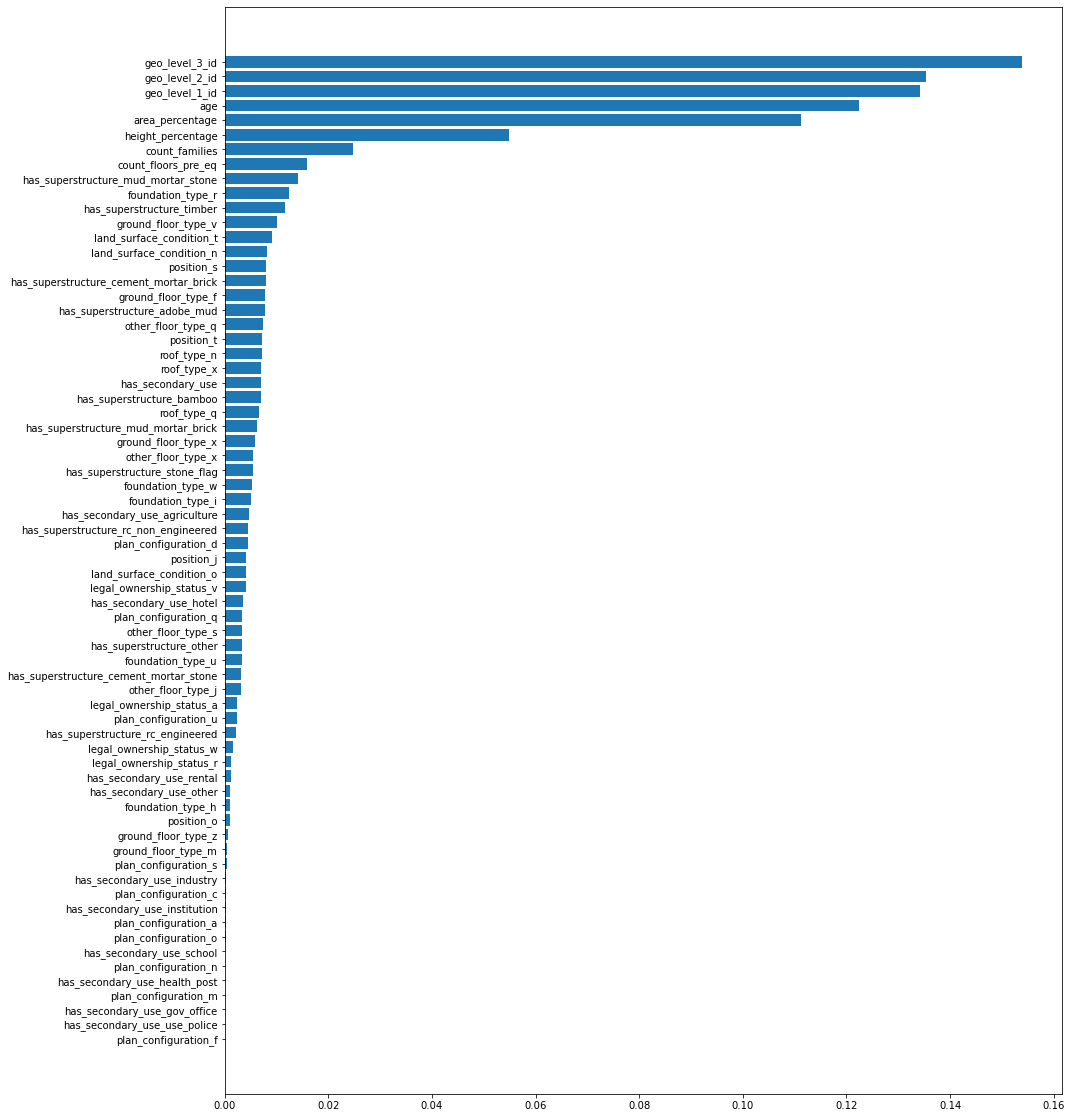

In [100]:
fig, ax = plt.subplots(figsize=(15,20))
ax.barh(feat_importances_df_sorted.index, feat_importances_df_sorted.importance);

In [101]:
less_important_feat = feat_importances_df[feat_importances_df.importance <= .005]
len(less_important_feat)

37

In [102]:
list(less_important_feat.index)

['has_superstructure_cement_mortar_stone',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other',
 'land_surface_condition_o',
 'foundation_type_h',
 'foundation_type_u',
 'ground_floor_type_m',
 'ground_floor_type_z',
 'other_floor_type_j',
 'other_floor_type_s',
 'position_j',
 'position_o',
 'plan_configuration_a',
 'plan_configuration_c',
 'plan_configuration_d',
 'plan_configuration_f',
 'plan_configuration_m',
 'plan_configuration_n',
 'plan_configuration_o',
 'plan_configuration_q',
 'plan_configuration_s',
 'plan_configuration_u',
 'legal_ownership_status_a',
 'legal_ownership_status_r',
 'legal_ownership_status_v',
 'l

In [103]:
#forest0_pipe.named_steps['transformer'].transformers[1][1].named_steps['ohe'].get_feature_names()

### forest1:  Try log transforming and scaling the integer columns

In [104]:
def log_transform(x):
    return np.log(x+1)

In [105]:
function_transformer = FunctionTransformer(log_transform)
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
ss_pipe = imbPipeline([('ss', StandardScaler())])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols),
    ('categorical', ohe_pipe, cat_cols),
    ('integer_log', function_transformer, integer_cols),
    ('integer_scale', ss_pipe, integer_cols),
    ('geo', 'passthrough', geo_cols)
])

In [106]:
forest1_pipe = imbPipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

In [107]:
start = time.time()
f1_micro_forest1 = cross_val_score(forest1_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_forest1 = end-start

Run time: 114.12560606002808


In [108]:
f1_micro_forest1 = f1_micro_forest1.mean()
f1_micro_forest1

0.7022512151445383

In [121]:
score_dict['forest1'] = [f1_micro_forest1, run_time_forest1]
print_scores()

forest0, f1_micro_score: 0.7094, Run time: 118.0
forest1, f1_micro_score: 0.7023, Run time: 114.0


Normalizing and scaling the integer columns do not affect the f1_micro score.

### forest2:  Try dropping less important features (importance < .005) to check performance and runtime

I will import the 'less important' features from the EDA notebook.

In [123]:
less_important_feat 
list(less_important_feat.index)

['has_superstructure_cement_mortar_stone',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other',
 'land_surface_condition_o',
 'foundation_type_h',
 'foundation_type_u',
 'ground_floor_type_m',
 'ground_floor_type_z',
 'other_floor_type_j',
 'other_floor_type_s',
 'position_j',
 'position_o',
 'plan_configuration_a',
 'plan_configuration_c',
 'plan_configuration_d',
 'plan_configuration_f',
 'plan_configuration_m',
 'plan_configuration_n',
 'plan_configuration_o',
 'plan_configuration_q',
 'plan_configuration_s',
 'plan_configuration_u',
 'legal_ownership_status_a',
 'legal_ownership_status_r',
 'legal_ownership_status_v',
 'l

In [124]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

In [125]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', 'passthrough', geo_cols)
])

In [126]:
forest2_pipe = imbPipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])
forest2_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                  ['land_surface_condition',
                                                   'foundation_type',
                                                   'roof_type',
 

In [127]:
start = time.time()
f1_micro_forest2 = cross_val_score(forest2_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_forest2 = end-start

Run time: 121.91436576843262


In [128]:
f1_micro_forest2 = f1_micro_forest2.mean()
f1_micro_forest2

0.7106114095676643

In [129]:
forest2_preds = forest2_pipe.predict(X_test)
forest2_test_score = f1_score(y_test, forest2_preds, average='micro')
forest2_test_score

0.7155070528464643

In [130]:
len(forest2_pipe.named_steps['rf'].feature_importances_)

49

In [131]:
score_dict['forest2'] = [f1_micro_forest2, run_time_forest2]
print_scores()

forest0, f1_micro_score: 0.7094, Run time: 118.0
forest1, f1_micro_score: 0.7023, Run time: 114.0
forest2, f1_micro_score: 0.7106, Run time: 122.0


### forest3 Try increasing feature importance to .01 and remove even more features

In [132]:
less_important_feat2 = feat_importances_df[feat_importances_df.importance <= .01]
len(less_important_feat2)

56

In [133]:
list(less_important_feat2.index)

['has_superstructure_adobe_mud',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other',
 'land_surface_condition_n',
 'land_surface_condition_o',
 'land_surface_condition_t',
 'foundation_type_h',
 'foundation_type_i',
 'foundation_type_u',
 'foundation_type_w',
 'roof_type_n',
 'roof_type_q',
 'roof_type_x',
 'ground_floor_type_f',
 'ground_floor_type_m',
 'ground_floor_type_x',
 'ground_floor_type_z',
 'other_floor_ty

In [134]:
binary_cols

['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [135]:
binary_cols_dropped2 = binary_cols.copy()
binary_cols_to_remove = ['has_superstructure_adobe_mud',
                         'has_superstructure_stone_flag',
                         'has_superstructure_cement_mortar_stone',
                         'has_superstructure_mud_mortar_brick',
                         'has_superstructure_cement_mortar_brick',
                         'has_superstructure_bamboo',
                         'has_superstructure_rc_non_engineered',
                         'has_superstructure_rc_engineered',
                         'has_superstructure_other',
                         'has_secondary_use',
                         'has_secondary_use_agriculture',
                         'has_secondary_use_hotel',
                         'has_secondary_use_rental',
                         'has_secondary_use_institution',
                         'has_secondary_use_school',
                         'has_secondary_use_industry',
                         'has_secondary_use_health_post',
                         'has_secondary_use_gov_office',
                         'has_secondary_use_use_police',
                         'has_secondary_use_other']
binary_cols_dropped2 = [x for x in binary_cols_dropped2 if x not in binary_cols_to_remove]

cat_cols_dropped2 = cat_cols.copy()
cat_cols_to_remove = ['legal_ownership_status', 'plan_configuration', 'other_floor_type', 'position', 
                      'roof_type', 'land_surface_condition']
cat_cols_dropped2 = [x for x in cat_cols_dropped2 if x not in cat_cols_to_remove]

In [136]:
cat_cols_dropped2

['foundation_type', 'ground_floor_type']

In [137]:
binary_cols_dropped2

['has_superstructure_mud_mortar_stone', 'has_superstructure_timber']

In [138]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped2),
    ('categorical', ohe_pipe, cat_cols_dropped2),
    ('integer', 'passthrough', integer_cols),
    ('geo', 'passthrough', geo_cols)
])

In [139]:
forest3_pipe = imbPipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])
forest3_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_timber']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['foundation_type',
                                                   'ground_floor_type']),
                                                 ('integer', 'passthrough',
                                                  ['count_floors_pre_eq', 'age',
                                                   'area_percentage',
      

In [140]:
start = time.time()
f1_micro_forest3 = cross_val_score(forest3_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_forest3 = end-start

Run time: 97.86826705932617


In [141]:
f1_micro_forest3 = f1_micro_forest3.mean()
f1_micro_forest3

0.7064210795599898

In [142]:
len(forest3_pipe.named_steps['rf'].feature_importances_)

20

In [143]:
score_dict['forest3'] = [f1_micro_forest3, run_time_forest3]
print_scores()

forest0, f1_micro_score: 0.7094, Run time: 118.0
forest1, f1_micro_score: 0.7023, Run time: 114.0
forest2, f1_micro_score: 0.7106, Run time: 122.0
forest3, f1_micro_score: 0.7064, Run time: 98.0


### forest4:  Try addressing the class imbalance using SMOTE

In [144]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', 'passthrough', geo_cols)
])

In [145]:
forest4_pipe = imbPipeline([
    ('transformer', transformer),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])
forest4_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
      

In [146]:
start = time.time()
f1_micro_forest4 = cross_val_score(forest4_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_forest4 = (end-start)

Run time: 201.53924202919006


In [147]:
f1_micro_forest4 = f1_micro_forest4.mean()
f1_micro_forest4

0.7042312611921208

In [148]:
forest4_preds = forest4_pipe.predict(X_test)
forest4_test_score = f1_score(y_test, forest4_preds, average='micro')
forest4_test_score

0.7111479486116867

In [149]:
score_dict['forest4'] = [f1_micro_forest4, run_time_forest4]
print_scores()

forest0, f1_micro_score: 0.7094, Run time: 118.0
forest1, f1_micro_score: 0.7023, Run time: 114.0
forest2, f1_micro_score: 0.7106, Run time: 122.0
forest3, f1_micro_score: 0.7064, Run time: 98.0
forest4, f1_micro_score: 0.7042, Run time: 202.0


### forest5:  Try Category Encoding

In [150]:
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
target_pipe = imbPipeline([('target', TargetEncoder())])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', target_pipe, geo_cols)
])

In [151]:
forest5_pipe = imbPipeline([
    ('transformer', transformer),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])
forest5_pipe.fit(X_train, y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['has_superstructure_adobe_mud',
                                                   'has_superstructure_mud_mortar_stone',
                                                   'has_superstructure_stone_flag',
                                                   'has_superstructure_cement_mortar_stone',
                                                   'has_superstructure_mud_mortar_brick',
                                                   'has_superstructure_cement_mortar_brick',
                                                   'has_superstructure_timber',
                                                   'has_superstr...
                                                   'foundation_type',
                                                   'roof_type',
                                                   'ground_floor_type',
      

In [152]:
start = time.time()
f1_micro_forest5 = cross_val_score(forest5_pipe, X_train, y_train, scoring='f1_micro')
end = time.time()
print(f'Run time: {end-start}')
run_time_forest5 = end-start

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif

Run time: 108.12692999839783


In [153]:
f1_micro_forest5 = f1_micro_forest5.mean()
f1_micro_forest5

0.7106114095676643

In [154]:
forest5_preds = forest5_pipe.predict(X_test)
forest5_test_score = f1_score(y_test, forest5_preds, average='micro')
forest5_test_score

0.7155070528464643

In [155]:
score_dict['forest5'] = [f1_micro_forest5, run_time_forest5]
print_scores()

forest0, f1_micro_score: 0.7094, Run time: 118.0
forest1, f1_micro_score: 0.7023, Run time: 114.0
forest2, f1_micro_score: 0.7106, Run time: 122.0
forest3, f1_micro_score: 0.7064, Run time: 98.0
forest4, f1_micro_score: 0.7042, Run time: 202.0
forest5, f1_micro_score: 0.7106, Run time: 108.0


In [156]:
f1_micro_forest5 == f1_micro_forest2

True